In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
raster_path = 'C:/Users/User/Quantum internship/T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_image = src.read()
    raster_meta = src.meta
del src

In [3]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

In [4]:
raster_image_ = reshape_as_image(raster_image)

MemoryError: Unable to allocate 345. MiB for an array with shape (10980, 10980, 3) and data type uint8

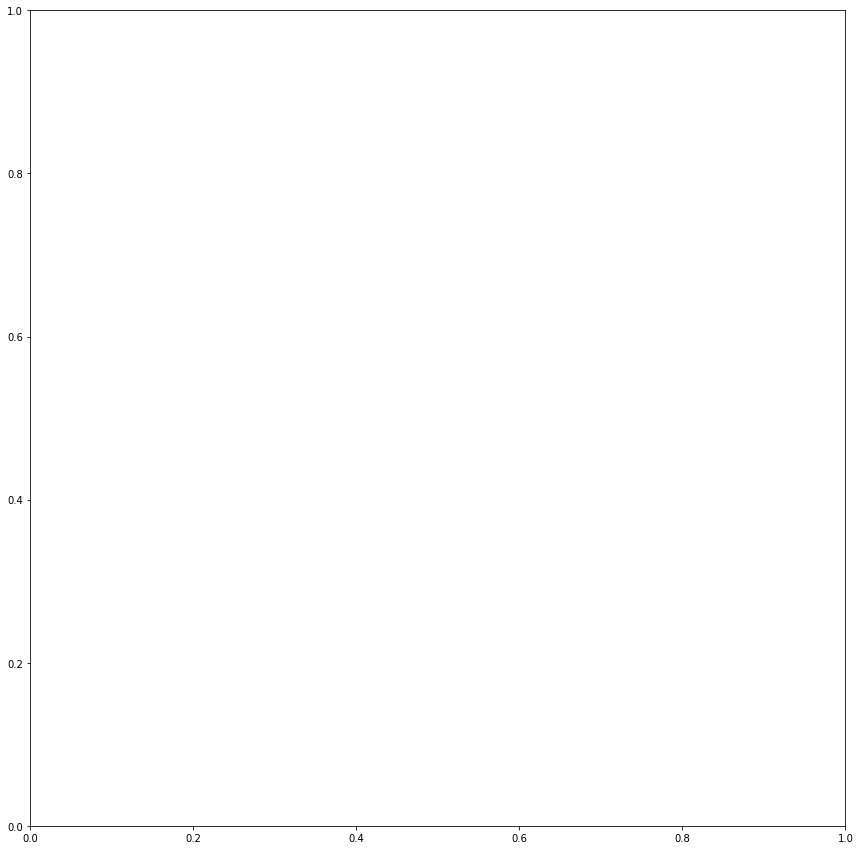

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(raster_image_)

In [17]:
from shapely import speedups
speedups.disable()

train_df = gpd.read_file("C:/Users/User/Quantum internship/masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [18]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


In [19]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

In [20]:
# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]
print(len(train_df))

# assigning crs
train_df.crs = {'init' :'epsg:4055'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

935


In [21]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "C:/Users/User/Quantum internship/images"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(num) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 435 files


In [22]:
def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

MemoryError: Unable to allocate 115. MiB for an array with shape (10980, 10980) and data type uint8

In [24]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("C:/Users/User/Quantum internship/result.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

CPLE_OutOfMemoryError: memdataset.cpp, 1513: cannot allocate 1x120560400 bytes